# Trigonometric time series model

In [1]:
%pylab inline
import pymc3 as pm
import theano.tensor as tt

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


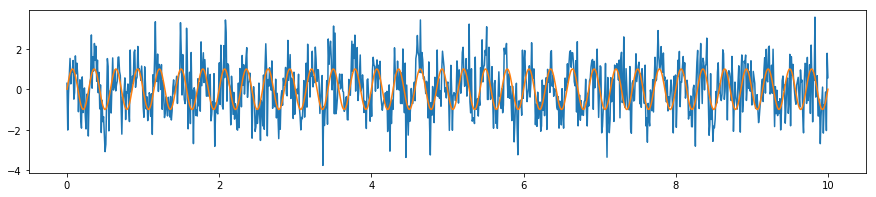

In [2]:
t = np.linspace(0., 10., 1000)
# 3.5Hz sine wave
func = lambda a, b, omega: a*np.sin(2*np.pi*omega*t)+b*np.cos(2*np.pi*omega*t)
y = func(1., 0., 3.5)
data = y + np.random.normal(size = t.shape[0])

_, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.plot(t, data)
ax.plot(t, y);

In [3]:
with pm.Model() as model:
    a = pm.Normal("a", mu=1, sd=2)
    b = pm.Normal("b", mu=1, sd=2)
    omega = pm.Gamma("omega", 1., 1.)
    regression = a * tt.sin(2 * np.pi * omega * t) +\
                 b * tt.cos(2 * np.pi * omega * t)
    sd = pm.HalfCauchy("sd", 0.5)
    observed = pm.Normal("observed",
                         mu=regression, 
                         sd=sd, 
                         observed=data)

WARNING (theano.gof.cmodule): The same cache key is associated to different modules (/Users/jlao/.theano/compiledir_Darwin-17.5.0-x86_64-i386-64bit-i386-3.5.1-64/tmp6mq4zwxw and /Users/jlao/.theano/compiledir_Darwin-17.5.0-x86_64-i386-64bit-i386-3.5.1-64/tmprc22erpn). This is not supposed to happen! You may need to manually delete your cache directory to fix this.
WARNING (theano.gof.cmodule): The same cache key is associated to different modules (/Users/jlao/.theano/compiledir_Darwin-17.5.0-x86_64-i386-64bit-i386-3.5.1-64/tmp6mq4zwxw and /Users/jlao/.theano/compiledir_Darwin-17.5.0-x86_64-i386-64bit-i386-3.5.1-64/tmprc22erpn). This is not supposed to happen! You may need to manually delete your cache directory to fix this.


In [4]:
with model:
    step1 = pm.Metropolis([omega])
    trace = pm.sample(10000, tune=5000, step=step1)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [omega]
>NUTS: [sd, b, a]
100%|██████████| 15000/15000 [00:48<00:00, 312.44it/s]
The number of effective samples is smaller than 10% for some parameters.


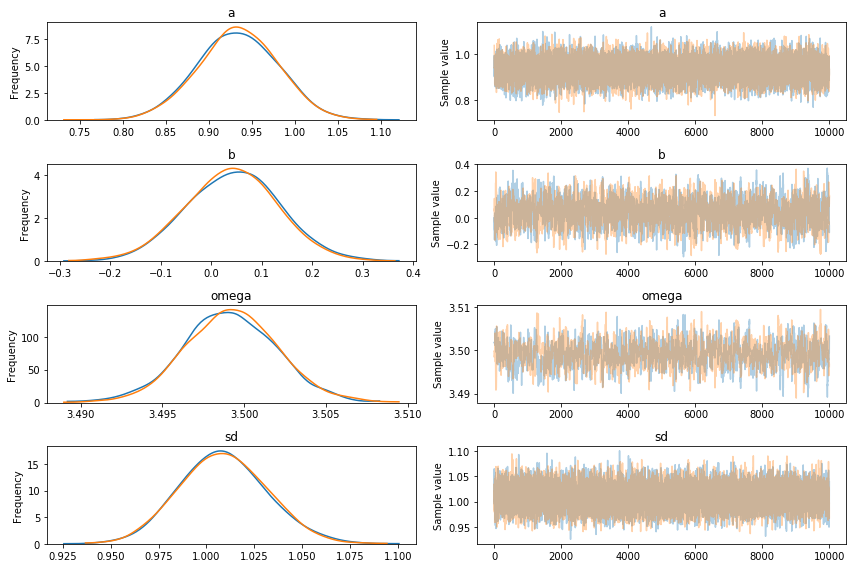

In [5]:
pm.traceplot(trace);

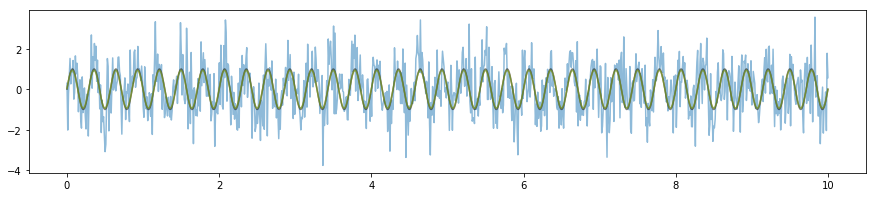

In [6]:
omegapost = trace.get_values(varname='omega', combine=False)
apost = trace.get_values(varname='a', combine=False)
bpost = trace.get_values(varname='b', combine=False)
_, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.plot(t, data, alpha=.5)
ax.plot(t, y, color='k', alpha=.5)
for ia, ib, io in zip(apost, bpost, omegapost):
    y_ = func(ia.mean(), ib.mean(), io.mean())
    ax.plot(t, y_,  alpha=.5);

In [7]:
with model:
    trace2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, omega, b, a]
100%|██████████| 2000/2000 [00:34<00:00, 57.61it/s] 
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6074042829378747, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9928100929598835, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


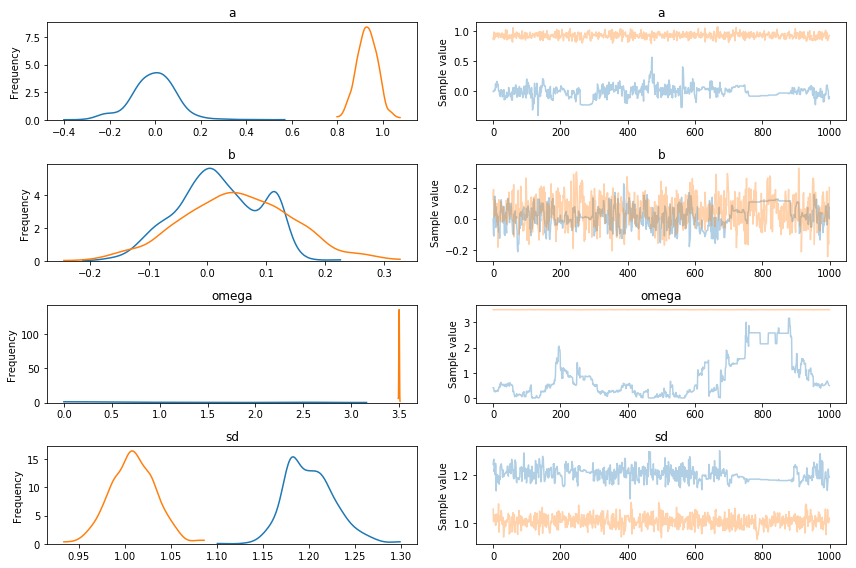

In [8]:
pm.traceplot(trace2);

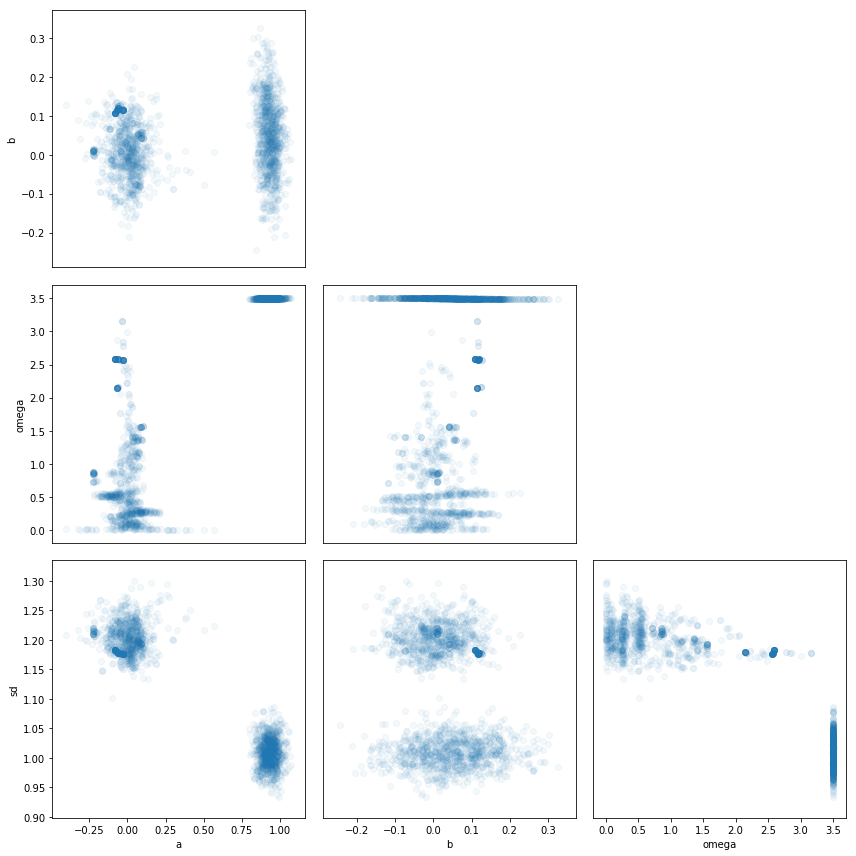

In [9]:
pm.pairplot(trace2, alpha=.05);

In [9]:
model.free_RVs

[a, b, omega_log__, sd_log__]

In [10]:
logp_dlogp_cond = model.logp_dlogp_function([model.free_RVs[0], 
                                             model.free_RVs[2]])

In [11]:
pt = model.test_point
pt

{'a': array(1.),
 'b': array(1.),
 'omega_log__': array(0.),
 'sd_log__': array(-0.69314718)}

In [12]:
pt['b'] = np.array(0.)
pt['sd_log__'] = np.log(0.5)
logp_dlogp_cond.set_extra_values(pt)

In [13]:
pt['a'] = np.array(2.)
pt

{'a': array(2.),
 'b': array(0.),
 'omega_log__': array(0.),
 'sd_log__': -0.6931471805599453}

In [14]:
logp_dlogp_cond.dict_to_array(pt)

array([2., 0.])

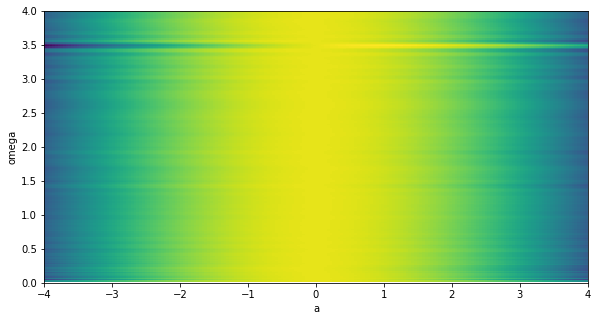

In [15]:
pt['b'] = np.array(0.)
pt['sd_log__'] = np.log(1.)
logp_dlogp_cond.set_extra_values(pt)
# grid search
omega_ = np.linspace(0, 4, 200)
a_ = np.linspace(-4, 4, 200)
ov_, av_ = np.meshgrid(omega_, a_)
logvec = np.asarray([logp_dlogp_cond(np.asarray([a__, np.log(o__)]))[0]
                    for o__, a__ in zip(ov_.flatten(), av_.flatten())])
ll = logvec.reshape(av_.shape)

_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(ll.T, cmap='viridis',
         extent=[a_[0], a_[-1], omega_[0], omega_[-1]], origin='lower'
         )
ax.set_xlabel('a')
ax.set_ylabel('omega');

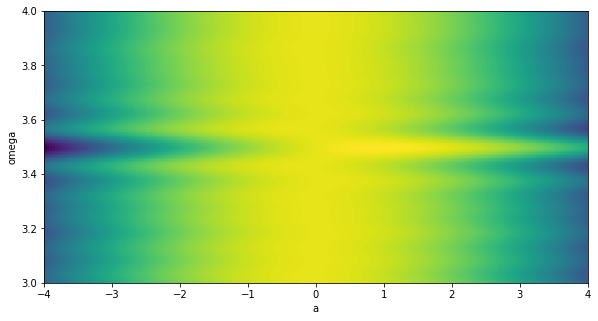

In [16]:
pt['b'] = np.array(0.)
pt['sd_log__'] = np.log(1.)
logp_dlogp_cond.set_extra_values(pt)
# grid search
omega_ = np.linspace(3, 4, 200)
a_ = np.linspace(-4, 4, 200)
ov_, av_ = np.meshgrid(omega_, a_)
logvec = np.asarray([logp_dlogp_cond(np.asarray([a__, np.log(o__)]))[0]
                    for o__, a__ in zip(ov_.flatten(), av_.flatten())])
ll = logvec.reshape(av_.shape)

_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(ll.T, cmap='viridis',
         extent=[a_[0], a_[-1], omega_[0], omega_[-1]], aspect=4, origin='lower'
         )
ax.set_xlabel('a')
ax.set_ylabel('omega');

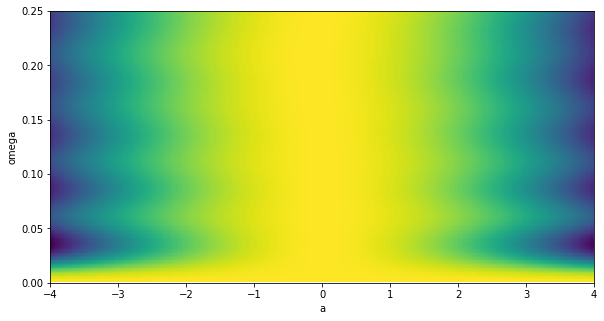

In [17]:
pt['b'] = np.array(0.)
pt['sd_log__'] = np.log(1.)
logp_dlogp_cond.set_extra_values(pt)
# grid search
omega_ = np.linspace(0, .25, 200)
a_ = np.linspace(-4, 4, 200)
ov_, av_ = np.meshgrid(omega_, a_)
logvec = np.asarray([logp_dlogp_cond(np.asarray([a__, np.log(o__)]))[0]
                    for o__, a__ in zip(ov_.flatten(), av_.flatten())])
ll = logvec.reshape(av_.shape)

_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(ll.T, cmap='viridis',
         extent=[a_[0], a_[-1], omega_[0], omega_[-1]], aspect=16, origin='lower'
         )
ax.set_xlabel('a')
ax.set_ylabel('omega');

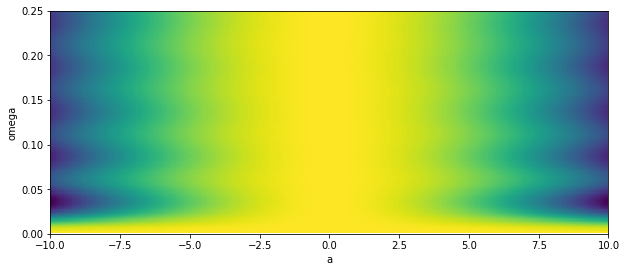

In [18]:
pt['b'] = np.array(0.)
pt['sd_log__'] = np.log(1.)
logp_dlogp_cond.set_extra_values(pt)
# grid search
omega_ = np.linspace(0, .25, 200)
a_ = np.linspace(-10, 10, 200)
ov_, av_ = np.meshgrid(omega_, a_)
logvec = np.asarray([logp_dlogp_cond(np.asarray([a__, np.log(o__)]))[0]
                    for o__, a__ in zip(ov_.flatten(), av_.flatten())])
ll = logvec.reshape(av_.shape)

_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(ll.T, cmap='viridis',
         extent=[a_[0], a_[-1], omega_[0], omega_[-1]], aspect=16*2, origin='lower'
         )
ax.set_xlabel('a')
ax.set_ylabel('omega');

GP

In [22]:
with pm.Model() as model:
    η_per = pm.HalfCauchy("η_per", beta=2, testval=1.0)
    period = pm.Normal("period", mu=1 / 3.5, sd=1.)
    periodic = η_per**2 * pm.gp.cov.Cosine(1, period)

    gp_periodic = pm.gp.Marginal(cov_func=periodic)

    noise = pm.HalfCauchy("noise", beta=2, testval=1.0)
    y_ = gp_periodic.marginal_likelihood(
        "y", X=t[:, np.newaxis], y=data, noise=noise)

In [23]:
mp = model.test_point
mp

{'noise_log__': array(0.),
 'period': array(0.28571429),
 'η_per_log__': array(0.)}

In [24]:
with model:
    mp = pm.find_MAP()
mp

logp = -1,419.6, ||grad|| = 1,151.2: 100%|██████████| 29/29 [00:09<00:00,  3.12it/s]  


{'noise': array(0.99133762),
 'noise_log__': array(-0.00870012),
 'period': array(0.28571457),
 'η_per': array(0.68636014),
 'η_per_log__': array(-0.37635281)}

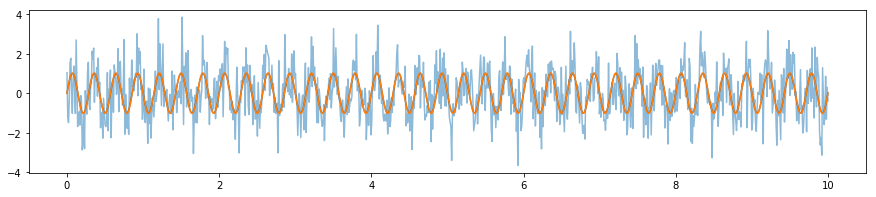

In [25]:
mp2 = mp
# mp2['noise_log__'] = np.log(1)
# mp2['η_per_log__'] = np.log(1)
# mp2['period'] = np.array(1/3.5)

mu_pred, cov_pred = gp_periodic.predict(t[:, np.newaxis], point=mp2)
_, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.plot(t, data, alpha=.5)
ax.plot(t, y, color='k', alpha=.5)
ax.plot(t, mu_pred)

In [26]:
model.free_RVs

[η_per_log__, period, noise_log__]

In [27]:
logp_dlogp_cond = model.logp_dlogp_function([model.free_RVs[0], model.free_RVs[1]])

In [28]:
pt = model.test_point
pt

{'noise_log__': array(0.),
 'period': array(0.28571429),
 'η_per_log__': array(0.)}

In [29]:
logp_dlogp_cond.set_extra_values(mp)

In [30]:
logp_dlogp_cond.dict_to_array(pt)

array([0.        , 0.28571429])

In [33]:
# grid search
omega_ = np.linspace(0, 4, 100)
a_ = np.linspace(0, 1, 100)
ov_, av_ = np.meshgrid(omega_, a_)
logvec = np.asarray([logp_dlogp_cond(np.asarray([np.log(a__), 1/o__]))[0]
                    for o__, a__ in zip(ov_.flatten(), av_.flatten())])

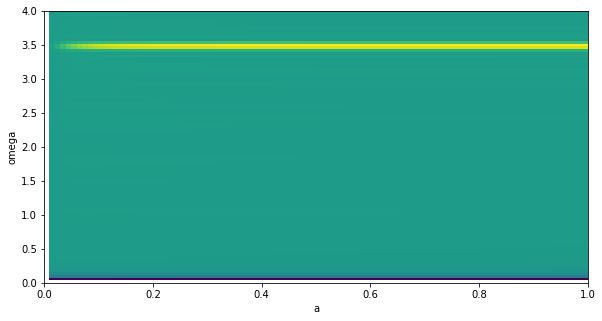

In [35]:
ll = logvec.reshape(av_.shape)

_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(ll.T, cmap='viridis',
         extent=[a_[0], a_[-1], omega_[0], omega_[-1]], aspect=1/16*2, origin='lower'
         )
ax.set_xlabel('a')
ax.set_ylabel('omega');